In [1]:
from function import *

2022-07-29 08:29:37.964439: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print(os.getcwd())
os.chdir("/home/wmbio/WORK/gitworking/Dependency_prediction/")
print(os.getcwd())

/home/wmbio/WORK/gitworking/Dependency_prediction/prediction/src
/home/wmbio/WORK/gitworking/Dependency_prediction


## **Data Load & Path**

In [4]:
TRAIN_PATH = "/home/wmbio/WORK/gitworking/Dependency_prediction/preprocessing/DATA/2022-07-28/"
TEMP_PATH = "prediction/train_preprocessing/"
SAVE_PATH = "prediction/custom_model/"

In [3]:
data_exp, sample_names_exp, property_names_exp = load_data(TRAIN_PATH + "training_custom_exp_training.txt")
if exists(TEMP_PATH + "train_exp_training.npy") is False:
    np.save(TEMP_PATH + 'train_exp_training.npy', data_exp)

 71%|██████████████████████████████████████████████████████▌                      | 4264/6016 [05:19<02:11, 13.33it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/wmbio/anaconda3/envs/deepdep/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3002998/2174411500.py", line 1, in <module>
    data_exp, sample_names_exp, property_names_exp = load_data(TRAIN_PATH + "training_custom_exp_training.txt")
  File "/home/wmbio/WORK/gitworking/Dependency_prediction/prediction/src/function.py", line 31, in load_data
    values = line.replace('\n', '').split('\t')
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wmbio/anaconda3/envs/deepdep/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

T

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/wmbio/anaconda3/envs/deepdep/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3002998/2174411500.py", line 1, in <module>
    data_exp, sample_names_exp, property_names_exp = load_data(TRAIN_PATH + "training_custom_exp_training.txt")
  File "/home/wmbio/WORK/gitworking/Dependency_prediction/prediction/src/function.py", line 31, in load_data
    values = line.replace('\n', '').split('\t')
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wmbio/anaconda3/envs/deepdep/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

T

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Read with databale
datatable_df = dt.fread(TRAIN_PATH + "training_custom_exp_training.txt", sep="\t")

In [12]:
# Then convert the dataframe into pandas
pandas_df = datatable_df.to_pandas()

In [ ]:
nparr = DT.to_numpy()

614727

In [19]:
sample_names = pandas_df.columns.to_list()[1:]
gene_names = pandas_df['Gene'].to_list()

In [ ]:
data = pandas_df.to_numpy()

In [13]:
if exists("prediction/data/ccl_complete_data_501CCL_1298DepOI_614727samples.npz") is False:
    # load TCGA mutation data, substitute here with other genomics
    data_exp, sample_names_exp, property_names_exp = load_data(TRAIN_PATH + "train_exp_training.txt")
    if exists(TEMP_PATH + "train_exp_training.npy") is False:
        np.save(TEMP_PATH + 'train_exp_training.npy', data_exp)

    data_mut, sample_names_mut, property_names_mut = load_data(TRAIN_PATH + "train_mut_training.txt")
    if exists(TEMP_PATH + "train_mut_training.npy") is False:
        np.save(TEMP_PATH + 'train_mut_training.npy', data_mut)

    data_cna, sample_names_cna, property_names_cna = load_data(TRAIN_PATH + "train_cna_training.txt")
    if exists(TEMP_PATH + "train_cna_training.npy") is False:
        np.save(TEMP_PATH + 'train_cna_training.npy', data_cna)

    data_meth, sample_names_meth, property_names_meth = load_data(TRAIN_PATH + "train_meth_training.txt")
    if exists(TEMP_PATH + "train_meth_training.npy") is False:
        np.save(TEMP_PATH + 'train_meth_training.npy', data_meth)

    data_dep, sample_names_dep, property_names_dep = load_data(TRAIN_PATH + "train_DepScore_training.txt")
    if exists(TEMP_PATH + "train_DepScore_training.npy") is False:
        np.save(TEMP_PATH + 'train_DepScore_training.npy', data_dep)

    data_fprint, sample_names_fprint, property_names_fprint = load_data(TRAIN_PATH + "train_fingerprint_training.txt")
    if exists(TEMP_PATH + "train_fingerprint_training.npy") is False:
        np.save(TEMP_PATH + 'train_fingerprint_training.npy', data_fprint)

    np.savez_compressed("prediction/data/ccl_complete_data_501CCL_1298DepOI_614727samples_custom.npz", 
                        data_exp=data_exp, data_mut=data_mut, data_cna=data_cna, data_meth=data_meth,
                        data_dep=data_dep, data_fprint=data_fprint)
else :
    data = np.load("prediction/data/ccl_complete_data_501CCL_1298DepOI_614727samples_custom.npz")
    data_exp = data['data_exp']
    data_mut = data['data_mut']
    data_cna = data['data_cna']
    data_meth = data['data_meth']
    data_fprint = data['data_fprint']
    data_dep = data['data_dep']

100%|██████████████████████████████████████████████████████████████████████████| 3115/3115 [00:00<00:00, 15862.13it/s]


## **Build Model**

* **Pretrained Model load - TCGA**

In [14]:
premodel_mut = pickle.load(open('prediction/data/premodel_tcga_mut_1000_100_50.pickle', 'rb'))
premodel_exp = pickle.load(open('prediction/data/premodel_tcga_exp_500_200_50.pickle', 'rb'))
premodel_cna = pickle.load(open('prediction/data/premodel_tcga_cna_500_200_50.pickle', 'rb'))
premodel_meth = pickle.load(open('prediction/data/premodel_tcga_meth_500_200_50.pickle', 'rb'))
print("\n\nDatasets successfully loaded.")



Datasets successfully loaded.


In [18]:
activation_func = 'relu' # for all middle layers
activation_func2 = 'linear' # for output layer to output unbounded gene-effect scores
init = 'he_uniform'
dense_layer_dim = 250
batch_size = 500
num_epoch = 100
num_DepOI = 1298 # 1298 DepOIs as defined in our paper, custom 1227
num_ccl = int(data_mut.shape[0]/num_DepOI)
split_ratio = 0.7

In [19]:
# 80% CCLs for training/validation, and 20% for testing
id_rand = np.random.permutation(num_ccl)
id_cell_train = id_rand[np.arange(0, round(num_ccl * split_ratio))]
id_cell_test = id_rand[np.arange(round(num_ccl * split_ratio), num_ccl)]
id_train = np.arange(0, num_DepOI) + id_cell_train[0]*num_DepOI
for y in id_cell_train:
    id_train = np.union1d(id_train, np.arange(0, num_DepOI) + y*num_DepOI)
id_test = np.arange(0, num_DepOI) + id_cell_test[0] * num_DepOI
for y in id_cell_test:
    id_test = np.union1d(id_test, np.arange(0, num_DepOI) + y*num_DepOI)
print("\n\nTraining/validation on %d samples (%d CCLs x %d DepOIs) and testing on %d samples (%d CCLs x %d DepOIs).\n\n" % (
    len(id_train), len(id_cell_train), num_DepOI, len(id_test), len(id_cell_test), num_DepOI))



Training/validation on 4908 samples (4 CCLs x 1227 DepOIs) and testing on 1227 samples (1 CCLs x 1227 DepOIs).




## **Fit & Evaluation Model**

### **(1) Full Model 4-Omics**

In [ ]:
train_generator = generator(data_mut[id_train], data_exp[id_train], data_cna[id_train], data_meth[id_train], 
                                    data_fprint[id_train], data_dep[id_train], batch_size = batch_size)

In [ ]:
test_generator = generator(data_mut[id_test], data_exp[id_test], data_cna[id_test], data_meth[id_test], 
                                    data_fprint[id_test], data_dep[id_test], batch_size = batch_size)

In [ ]:
model = full_model()
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
model.compile(loss='mse', optimizer='adam', metrics=[coeff_determination])
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=num_epoch, verbose=1,         
                    callbacks = [es])

In [ ]:
SAVE_NAME = "model_custom_full_0720"
model.save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\nFull DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))

In [ ]:
model_train_vis(history=history)

### **(2) Expression-Mutation-CNA Model**

In [ ]:
train_generator = generator3(data_mut[id_train], data_exp[id_train], data_cna[id_train], 
                                    data_fprint[id_train], data_dep[id_train], batch_size = batch_size)

In [ ]:
test_generator = generator3(data_mut[id_test], data_exp[id_test], data_cna[id_test],
                                    data_fprint[id_test], data_dep[id_test], batch_size = batch_size)

In [ ]:
model = exp_mut_cna_model()
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
model.compile(loss='mse', optimizer='adam', metrics=[coeff_determination])
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=num_epoch, verbose=1,         
                    callbacks = [es])

In [ ]:
SAVE_NAME = "model_custom_mut_exp_cna_0725"
model.save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\nFull DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))

In [ ]:
model_train_vis(history=history)

### **(3) Expression-Mutation Model**

In [ ]:
train_generator = generator2(data_mut[id_train], data_exp[id_train], data_fprint[id_train],
                            data_dep[id_train], batch_size = batch_size)

In [ ]:
test_generator = generator2(data_mut[id_test], data_exp[id_test], data_fprint[id_test],
                           data_dep[id_test], batch_size = batch_size)

In [ ]:
model = exp_mut_model()
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
model.compile(loss='mse', optimizer='adam', metrics=[coeff_determination])
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=num_epoch, verbose=1,         
                    callbacks = [es])

In [ ]:
model_train_vis(history=history)

In [ ]:
SAVE_NAME = "model_custom_mut_exp_0720"
model.save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\nFull DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))

### **(4) Expression Model**

In [20]:
train_generator = generator1(data_exp[id_train], data_fprint[id_train],
                            data_dep[id_train], batch_size = batch_size)

In [21]:
test_generator = generator1(data_exp[id_test], data_fprint[id_test],
                           data_dep[id_test], batch_size = batch_size)

In [23]:
with tf.device('/cpu:0'):
    model = exp_model()
    tf.keras.utils.plot_model(model, show_shapes=True,  show_dtype=True, to_file='model_custom.png')
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
    model.compile(loss='mse', optimizer='adam', metrics=[coeff_determination])
    history = model.fit(train_generator, 
                        validation_data=test_generator, 
                        # epochs=num_epoch, 
                        epochs=100, 
                        verbose=1,         
                        callbacks = [es])

Epoch 1/100
10/10 [==============================] - 0s 33ms/step - loss: 13.4187 - coeff_determination: -37.6438 - val_loss: 0.2705 - val_coeff_determination: 0.0355
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 0.2991 - coeff_determination: -0.0335 - val_loss: 0.1830 - val_coeff_determination: 0.3314
Epoch 3/100
10/10 [==============================] - 0s 25ms/step - loss: 0.1916 - coeff_determination: 0.3104 - val_loss: 0.1217 - val_coeff_determination: 0.5487
Epoch 4/100
10/10 [==============================] - 0s 25ms/step - loss: 0.1135 - coeff_determination: 0.5590 - val_loss: 0.0888 - val_coeff_determination: 0.6605
Epoch 5/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0751 - coeff_determination: 0.7237 - val_loss: 0.0675 - val_coeff_determination: 0.7426
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 0.0574 - coeff_determination: 0.8019 - val_loss: 0.0602 - val_coeff_determination: 0.7720
Epoch 7/100


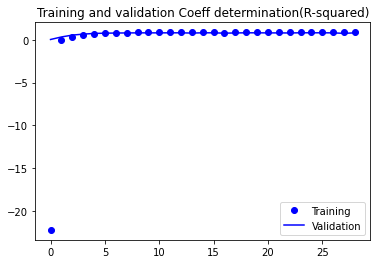

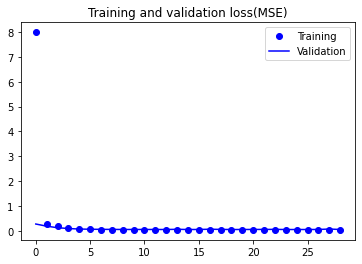

In [24]:
model_train_vis(history=history)

In [25]:
SAVE_NAME = "model_ccl501_exp_0728"
model.save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\nFull DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))



Full DeepDEP model saved in prediction/custom_model/model_ccl501_exp_0728.h5




### **(5) Mutation Model**

In [ ]:
train_generator = generator1(data_mut[id_train], data_fprint[id_train],
                            data_dep[id_train], batch_size = batch_size)

In [ ]:
test_generator = generator1(data_mut[id_test], data_fprint[id_test],
                           data_dep[id_test], batch_size = batch_size)

In [ ]:
model = mut_model()
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
model.compile(loss='mse', optimizer='adam', metrics=[coeff_determination])
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=num_epoch, verbose=1,         
                    callbacks = [es])

In [ ]:
model_train_vis(history=history)

In [ ]:
SAVE_NAME = "model_custom_mut_0720"
model.save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\nFull DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))

### **(6) CNA Model**

In [ ]:
train_generator = generator1(data_cna[id_train], data_fprint[id_train],
                            data_dep[id_train], batch_size = batch_size)

In [ ]:
test_generator = generator1(data_cna[id_test], data_fprint[id_test],
                           data_dep[id_test], batch_size = batch_size)

In [ ]:
model = mut_model()
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
model.compile(loss='mse', optimizer='adam', metrics=[coeff_determination])
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=num_epoch, verbose=1,         
                    callbacks = [es])

In [ ]:
model_train_vis(history=history)

In [ ]:
SAVE_NAME = "model_custom_cna_0726"
model.save(SAVE_PATH + SAVE_NAME + ".h5")
print("\n\nFull DeepDEP model saved in %s\n\n" % (SAVE_PATH + SAVE_NAME + ".h5"))